In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reviews-cleaned/reviews_cleaned.csv


# Women's Clothing Reviews - Sentiment Analysis: Building Word2Vec

## Overall Project Goal
In this project I want to understand this dataset on women's clothing reviews, create a Word2Vec model based off of the review texts in the data set and then use this Word2Vec model to build a sentiment analysis model on the dataset which attempts to predict whether the customer left a 5-star review or not.

### Project Notebooks
This notebook is part of a series of 3 notebooks on performing sentiment analysis on a dataset of women's clothing reviews.
1. Women's Clothing Reviews - Sentiment Analysis: EDA **{ADD LINKS}**
2. **Women's Clothing Reviews - Sentiment Analysis: Building Word2Vec Model** 
3. Women's Clothing Reviews - Sentiment Analysis: Building a Sentiment Analysis Model



## Goal of this notebook: Building Word2Vec Model
In this notebook, I want to take all the text in the dataset, preprocess it and use it to build a Word2Vec model that can then be used to vectorise the data and use it in a neural network for the task of sentiment analysis.

In [2]:
# Linear algebra and data processing
import pandas as pd
import numpy as np

# Data vizualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data preprocessing
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

# Importing the model
from gensim.models import word2vec, Phrases

In [3]:
# Loading the cleaned dataset from the EDA notebook
data = pd.read_csv('/kaggle/input/reviews-cleaned/reviews_cleaned.csv', index_col='Unnamed: 0')

In [4]:
# Looking at the first 5 rows of the dataset
data.head()

,Title,Review Text,Five Star
0,NaN,Absolutely wonderful - silky and sexy and comf...,0
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


## 1. Data Preprocessing

In this step, the data needs to be preprocessed in order to be used to create the Word2Vec model. The preprocessing steps include:
- Removing HTML
- Removing non-letters
- Converting all to lowercase
- Lemmatization of the words

To create the Word2Vec model a tokeniser will be used to split the text into sentences and the sentences will be split into a list of preprocessed words (so we will have a list of lists format). Also we will take the reviews that contain a title and add the title to the review text so that we can build the model based on the entirety of the text available.

In [5]:
# Replace missing values with a space character
data['Title'] = data['Title'].apply(lambda x: ' ' if pd.isna(x) else x)

# Creating a new column that contains the title and review text together
data['Total Text'] = data['Title'] + '. ' +data['Review Text'] 

In [6]:
# importing a lemmatizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def lemmatize(words):
    # This function takes in a list of words and returns the list
    # of words with the words in their lemmatized form
    # it priotizes correctly lemmatizing verbs
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return lemmatized_words


In [7]:
def review_to_wordlist(review):
    
    # This is our data preprocessing function that removes HTML, removes non letters and 
    # returns the review with words split into items in a list and all in lowercase.
    
    # Remove HTML
    review = BeautifulSoup(review).get_text()
    
    # Remove non-letters
    review = re.sub("[^a-zA-Z]", " ", review)
    
    # Convert words to lowercase and split them
    review = review.lower().split()
    
    # Converting stopwords list to a set (for processing time)
    stops = set(stopwords.words("english"))
    
    # Removing stopwords
    review = [w for w in review if not w in stops]
    
    # Lemmatize the words
    review = lemmatize(review)
    
    
    return review

In [8]:
# Preprocessing data so that it can be used in the model building notebook
data_preprocessed = data.copy()
data_preprocessed['Total Text'] = data['Total Text'].apply(lambda review: review_to_wordlist(review))
data_preprocessed.to_csv('data_preprocessed.csv', index=False)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [9]:
# Example of results of review_to_wordlist
review_to_wordlist(data['Review Text'][1])[:10]

['love',
 'dress',
 'sooo',
 'pretty',
 'happen',
 'find',
 'store',
 'glad',
 'bc',
 'never']

Word2Vec expects to recieve text in a specific format. It expects single sentences as a list of words. The input format is therefore a list of lists breaking down the text into sentences and words. We will use the tokenizer to define the different sentences in the text.

In [10]:
# Download the punkt tokenizer for sentence splitting
import nltk.data

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
def review_to_sentences(review, tokenizer):
    # This function splits the review into passed sentences
    # and returns a list of sentences, where each sentence is a list of words
    
    # Using the tokeniser to split the reivew into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    
    # Creating an empty list to append the preprocessed lists of words to
    sentences = []
    
    # Iterating over the sentences split by the tokeniser
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            # Using the review_to_wordlist function to return a list of lists
            sentences.append(review_to_wordlist(raw_sentence))

    return sentences
        

In [12]:
# Defining the empty list to put the sentences in
sentences = []

# Preprocessing the reviews in `train_labeled` and appending to list
for i, review in enumerate(data['Total Text']):
    if i%5000 == 0:
        print(f'{i} reviews processed in data out of {len(data)}')
    sentences += review_to_sentences(review, tokenizer)

0 reviews processed in data out of 22641
5000 reviews processed in data out of 22641
10000 reviews processed in data out of 22641
15000 reviews processed in data out of 22641
20000 reviews processed in data out of 22641


In [13]:
# Seeing how many sentences and words are in the corpus
num_sent = len(sentences)
num_words = sum(len(sentence) for sentence in sentences)

# Printing the number of sentences and words
print(f'The dataset contains {num_sent:,} sentences and a total of {num_words:,} words')

The dataset contains 131,187 sentences and a total of 685,461 words


## 2. Analysing the Corpus of Text

Lets take a look at the different word frequencies to get a better understanding of the corpus of text we are going to train the Word2Vec model on.

In [14]:
# Creating an empty dictionary to add in words and their frequencies
word_frequencies = {}

# Iterating through sentences, then words and adding up their frequencies in the dictionary
for sentence in sentences:
    for word in sentence:
        if word in word_frequencies:
            word_frequencies[word] += 1
        else:
            word_frequencies[word] = 1

In [15]:
# Convert the dictionary into a list of tuples
word_freq_list = [(word, freq) for word, freq in word_frequencies.items()]

# Create a pandas dataframe from the list
word_freqs = pd.DataFrame(word_freq_list, columns=['Word', 'Frequency'])

# Sort the dataframe by frequency in descending order and reseting the index
word_freqs = word_freqs.sort_values(by='Frequency', ascending=False)
word_freqs = word_freqs.reset_index(drop=True)

In [16]:
# Creating subsets which show words greater than certain frequencies
word_freqs_100 = word_freqs[word_freqs['Frequency'] > 100]
word_freqs_500 = word_freqs[word_freqs['Frequency'] > 500]

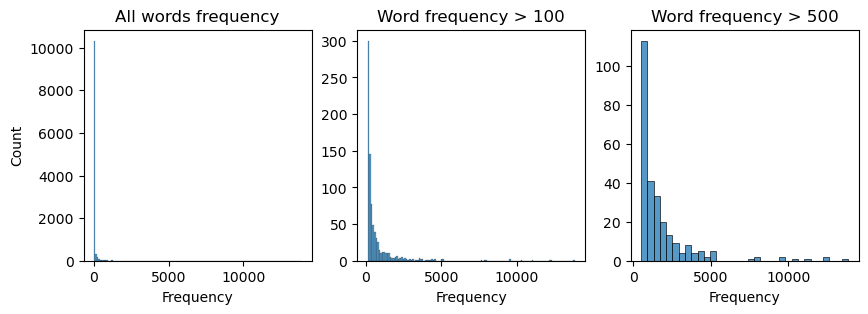

In [17]:
# Creating a figure to plot histograms for word frequency distributions
fig = plt.figure(figsize=(10,3))

# Word frequency distribution for all words
plt.subplot(1,3,1)
sns.histplot(word_freqs['Frequency'], bins = 150)
plt.title('All words frequency')

# Word frequency distribution for words with a frequency above 100
plt.subplot(1,3,2)
sns.histplot(word_freqs_100['Frequency'])
plt.title('Word frequency > 100')
plt.ylabel('')

# Word frequency distribution for words with a frequency above 500
plt.subplot(1,3,3)
sns.histplot(word_freqs_500['Frequency'])
plt.title('Word frequency > 500')
plt.ylabel('')


plt.show()

Here we can clearly see that the word frequencies have a heavily right skewed distribution. A small group of words have an extremely high frequency and the reset of the words have quite a low frequency.

## 3. Training the Word2Vec model

Now that we have the corpus of text preprocessed and in the correct format we can train our Word2Vec model. First we will find bigrams and trigrams in the corpus and then train the model.

In [18]:
# Finding bigrams from the corpus
bigrams = Phrases(sentences=sentences)

In [19]:
# Finding trigrams from the corpus
trigrams = Phrases(sentences=bigrams[sentences])

In [20]:
# This is so we can see how the training is going
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
print(logging.getLogger().isEnabledFor(logging.INFO))

# Defining the model parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 20          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


# Calling the model
model = word2vec.Word2Vec(
    sentences=trigrams[bigrams[sentences]], 
    workers=num_workers,
    vector_size=num_features, 
    min_count=min_word_count,
    window=context,
    sample=downsampling,
)

# Makes the model more memory efficient
model.init_sims(replace=True)

# Saving the model
model_name = "wcr_trigrams_300features_5minwords_20context.bin" # 'wcr' stands for womens clothes reviews
model.wv.save_word2vec_format(model_name, binary=True)

True


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).


## 4. Exploring the Word2Vec Model

In [21]:
# Get the vocabulary size
vocab_size = len(model.wv.key_to_index)
print("Vocabulary size:", vocab_size)

Vocabulary size: 5291


In [22]:
model.wv.most_similar('yellow')

[('purple', 0.982776403427124),
 ('green', 0.9761893153190613),
 ('orange', 0.9716302156448364),
 ('gray', 0.9687690734863281),
 ('red', 0.9669089913368225),
 ('peach', 0.9661256670951843),
 ('pink', 0.9620094299316406),
 ('blue', 0.9609580039978027),
 ('shade', 0.9602628350257874),
 ('coral', 0.9574291706085205)]

In [23]:
model.wv.most_similar('small')

[('large', 0.9557020664215088),
 ('l', 0.9044143557548523),
 ('normal_size', 0.8949816226959229),
 ('larger', 0.8788132667541504),
 ('ft_inch_lbs', 0.8786118626594543),
 ('normal', 0.8722407817840576),
 ('sometimes', 0.8645698428153992),
 ('snug', 0.8635272979736328),
 ('usual_size', 0.8630632162094116),
 ('big', 0.8612691164016724)]

In [24]:
model.wv.most_similar('love')

[('adorable', 0.7121343016624451),
 ('fantastic', 0.6848126649856567),
 ('amaze', 0.6844492554664612),
 ('awesome', 0.6833465695381165),
 ('similar', 0.6385232210159302),
 ('different', 0.6361136436462402),
 ('fabulous', 0.6262713670730591),
 ('notch', 0.6209169030189514),
 ('cute', 0.6113894581794739),
 ('absolutely_gorgeous', 0.6103411912918091)]

The model appears to have done reasonably well at picking up some word similarities.

# Possible Extensions

To improve the accuracy and increase the vocabulary of the model, **more text data could be used**. The text data should be similar to the corpus of text we have so that the model can train on similar words and sees the words in similar contexts.
    